In [9]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import emcee
import corner
import chainconsumer

import parameter_estimation_micro_qcd
import axion_mass
import g_star
import eom
import time_temp
import potential
import config
import density_plot
import solver2

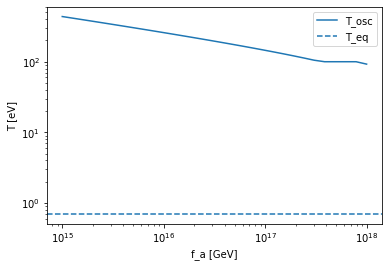

In [10]:
T_i_s = [time_temp.find_T_osc(f, 
                     lambda T, f: axion_mass.micro_m_a(T, f, 1e2, .5),
                     # g_star.make_micro(parameter_estimation_micro_qcd.Delta_N_eff_mean))
                     g_star.make_micro(3))
         for f in f_a]

plt.loglog(f_a / 1e9, T_i_s, label="T_osc")
plt.axhline(config.parameter.T_eq, label="T_eq", linestyle="--")
plt.xlabel("f_a [GeV]")
plt.ylabel("T [eV]")
plt.legend()

In [11]:
df = np.load(config.data_path + "/micro_qcd_parameter.npz")
samples = df["samples"]
single_chains = samples.reshape((-1, 5))
names = ["theta_i", "log f_a"] + parameter_estimation_micro_qcd.parameter_names

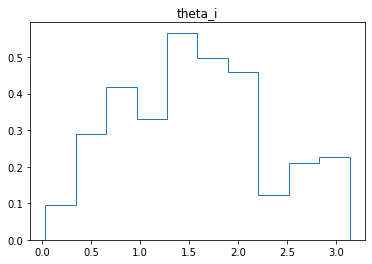

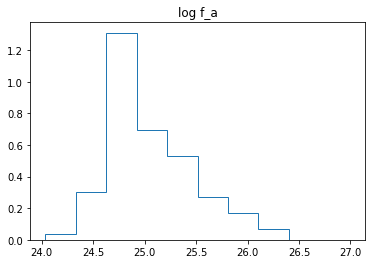

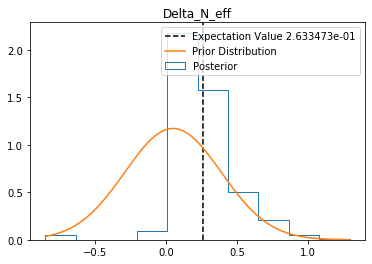

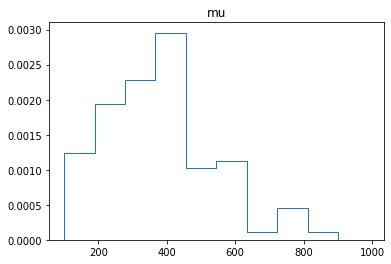

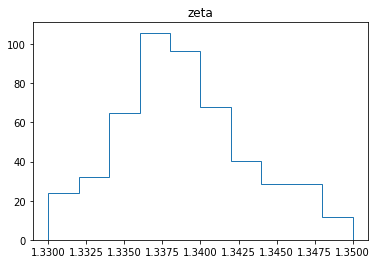

In [3]:
for i, name in enumerate(names):
    plt.title(name)
    plt.hist(single_chains[:, i], density=True, histtype="step", label="Posterior")
    if name == "Delta_N_eff":
        Delta_N_effs = single_chains[:, i]
        Delta_N_eff_expectation_value = np.mean(Delta_N_effs)
        plt.axvline(Delta_N_eff_expectation_value, label="Expectation Value %e" % Delta_N_eff_expectation_value, 
                    color="black", linestyle="--")
        Delta_N_effs = np.linspace(np.min(Delta_N_effs), np.max(Delta_N_effs), 300)
        plt.plot(Delta_N_effs, np.exp(parameter_estimation_micro_qcd.log_gaussian(Delta_N_effs,
            parameter_estimation_micro_qcd.Delta_N_eff_mean, parameter_estimation_micro_qcd.Delta_N_eff_err)),
                label="Prior Distribution")
        plt.legend()
    plt.show()

In [36]:
#corner.corner(single_chains, labels=names)

In [5]:
mu = single_chains[:, -2]
m_psi = mu / 2
f_a = 10**single_chains[:, 1]
m_a = np.sqrt(mu**3 * m_psi) / f_a

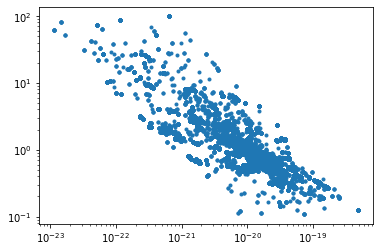

In [6]:
n = 10000
# plt.semilogx(m_a[:n], f_a[:n] / (1e16 * 1e9) , ".")
plt.loglog(m_a, f_a / (1e16 * 1e9) , ".")
#plt.ylim((0, 40))
#plt.xlim((1e-22, 1e-21))
plt.xlabel("m_a / eV")
plt.ylabel("f_a / (1e16 GeV)")

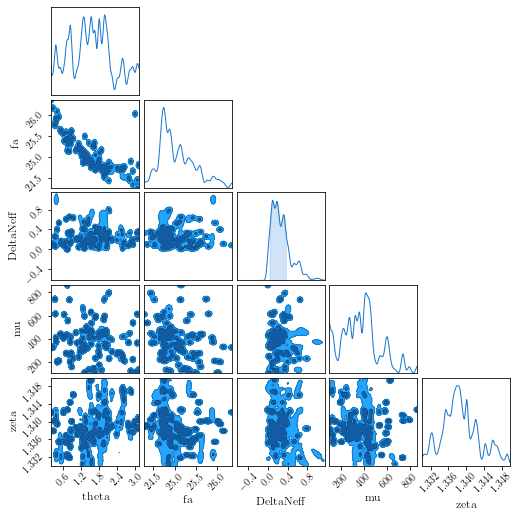

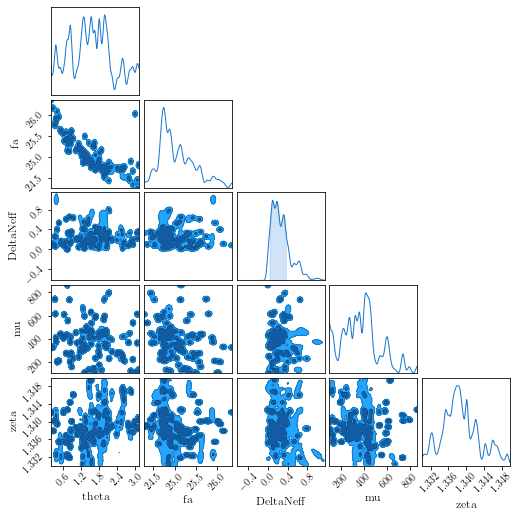

In [8]:
c = chainconsumer.ChainConsumer()
names = ["theta", "fa", "DeltaNeff", "mu", "zeta"]
c.add_chain(single_chains, parameters=names)
c.plotter.plot()

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

Text(0, 0.5, 'f_a / (1e16 * GeV)')

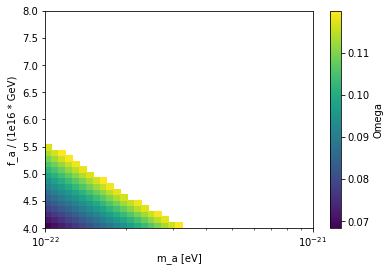

In [23]:
N = 40
theta_i = 1
f_a = np.linspace(4, 8, N) * 1e16 * 1e9
m_a = np.logspace(-22, -21, N)
Omega = np.array([[parameter_estimation_micro_qcd.compute_Omega(theta_i, f, 
                                            parameter_estimation_micro_qcd.Delta_N_eff_mean,
                                            np.sqrt(np.sqrt(2) * f * m),
                                            parameter_estimation_micro_qcd.zeta_mean)
          for m in m_a] for f in f_a])

O = Omega.copy()
O[O > config.parameter.Omega_DM_h_sq] = np.NAN
ax = plt.gca()
plt.pcolormesh(m_a, f_a / (1e16 * 1e9), O)
ax.set_xscale("log")
cbar = plt.colorbar()
cbar.set_label("Omega")
ax.set_xlabel("m_a [eV]")
ax.set_ylabel("f_a / (1e16 * GeV)")

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

Text(0, 0.5, 'f_a / (1e16 * GeV)')

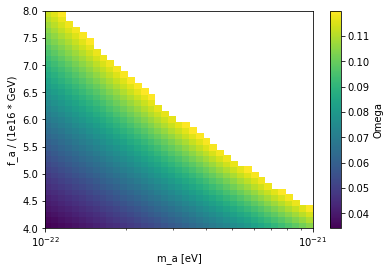

In [24]:
N = 40
theta_i = 1 / np.sqrt(2)
f_a = np.linspace(4, 8, N) * 1e16 * 1e9
m_a = np.logspace(-22, -21, N)
Omega = np.array([[parameter_estimation_micro_qcd.compute_Omega(theta_i, f, 
                                            parameter_estimation_micro_qcd.Delta_N_eff_mean,
                                            np.sqrt(np.sqrt(2) * f * m),
                                            parameter_estimation_micro_qcd.zeta_mean)
          for m in m_a] for f in f_a])

O = Omega.copy()
O[O > config.parameter.Omega_DM_h_sq] = np.NAN
ax = plt.gca()
plt.pcolormesh(m_a, f_a / (1e16 * 1e9), O)
ax.set_xscale("log")
cbar = plt.colorbar()
cbar.set_label("Omega")
ax.set_xlabel("m_a [eV]")
ax.set_ylabel("f_a / (1e16 * GeV)")

In [18]:
config.parameter.Omega_DM_h_sq

0.12002618500000002

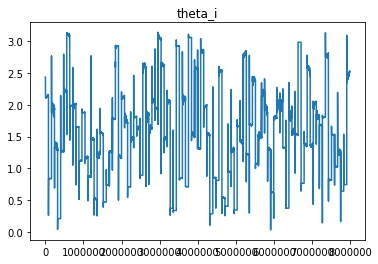

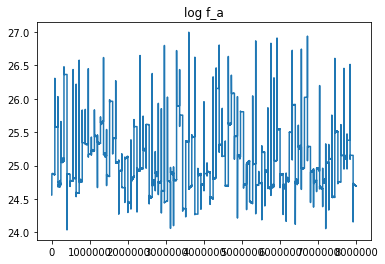

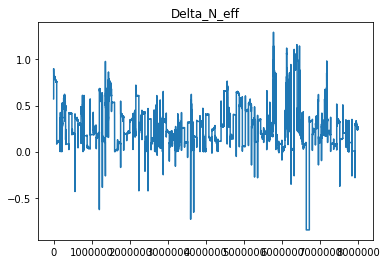

In [ ]:
for i, name in enumerate(names):
    plt.plot(single_chains[:, i])
    plt.title(name)
    plt.show()

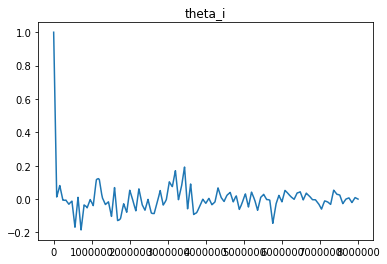

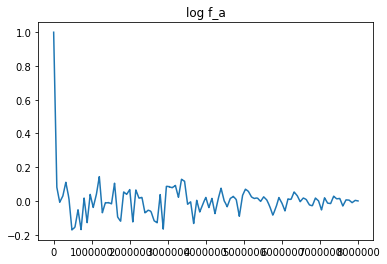

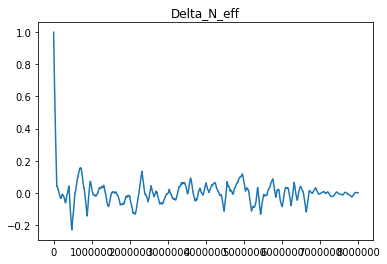

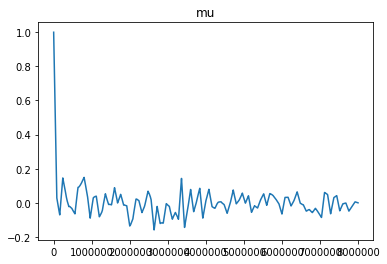

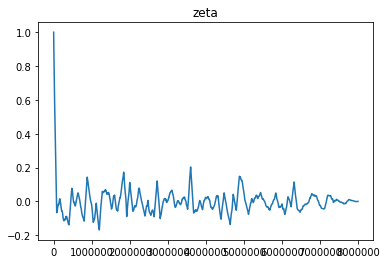

In [3]:
for i, name in enumerate(names):
    c = emcee.autocorr.function(single_chains[:, i])
    plt.plot(c)
    plt.title(name)
    plt.show()

In [3]:
def compute_Omega_numerical(f_a, theta_i):
    print(f_a, theta_i)
    Delta_N_eff = parameter_estimation_micro_qcd.Delta_N_eff_mean
    mu = 1e2
    zeta = parameter_estimation_micro_qcd.zeta_mean
    micro_quark_mass = mu / 2
    N_f = 1
    N_mu = 3
    kappa = (11 * N_mu - 2 * N_f) / 6
    c_N = 0.26 / (zeta**(N_mu - 2) * math.factorial(N_mu - 1) * math.factorial(N_mu - 2))
    eta = kappa + N_f / 2 - 2
    m_psi = mu / 2
    p = (Delta_N_eff, mu, micro_quark_mass, zeta, N_f, N_mu, kappa, c_N, eta, m_psi)
    return solver2.compute_relic_density(*p, theta_i, f_a)

N = 30
f_a = np.logspace(15, 18, N) * 1e9
theta_i = np.logspace(-5, np.log10(3), N)

In [3]:
def compute_Omega_analytic(f_a, theta_i):
    return parameter_estimation_micro_qcd.compute_Omega(theta_i, f_a, 
                                                parameter_estimation_micro_qcd.Delta_N_eff_mean,
                                                1e2,
                                                parameter_estimation_micro_qcd.zeta_mean)

In [4]:
%time Omega_numerical = np.array([[compute_Omega_numerical(f, t) for f in f_a] for t in theta_i])
%time Omega_analytic = np.array([[compute_Omega_analytic(f, t) for f in f_a] for t in theta_i])

1e+24 1e-05
1.26896100317e+24 1e-05
1.61026202756e+24 1e-05
2.04335971786e+24 1e-05
2.5929437974e+24 1e-05
3.29034456231e+24 1e-05
4.17531893656e+24 1e-05
5.29831690628e+24 1e-05
6.7233575365e+24 1e-05
8.53167852417e+24 1e-05
1.08263673387e+25 1e-05
1.37382379588e+25 1e-05
1.7433288222e+25 1e-05
2.21221629107e+25 1e-05
2.80721620394e+25 1e-05
3.56224789026e+25 1e-05
4.52035365636e+25 1e-05
5.73615251045e+25 1e-05
7.27895384398e+25 1e-05
9.23670857187e+25 1e-05
1.17210229753e+26 1e-05
1.48735210729e+26 1e-05
1.88739182214e+26 1e-05
2.39502661999e+26 1e-05
3.03919538231e+26 1e-05
3.85662042116e+26 1e-05
4.89390091848e+26 1e-05
6.21016941892e+26 1e-05
7.88046281567e+26 1e-05
1e+27 1e-05
1e+24 1.54477862021e-05
1.26896100317e+24 1.54477862021e-05
1.61026202756e+24 1.54477862021e-05
2.04335971786e+24 1.54477862021e-05
2.5929437974e+24 1.54477862021e-05
3.29034456231e+24 1.54477862021e-05
4.17531893656e+24 1.54477862021e-05
5.29831690628e+24 1.54477862021e-05
6.7233575365e+24 1.54477862021e-

3.29034456231e+24 0.000324287345165
4.17531893656e+24 0.000324287345165
5.29831690628e+24 0.000324287345165
6.7233575365e+24 0.000324287345165
8.53167852417e+24 0.000324287345165
1.08263673387e+25 0.000324287345165
1.37382379588e+25 0.000324287345165
1.7433288222e+25 0.000324287345165
2.21221629107e+25 0.000324287345165
2.80721620394e+25 0.000324287345165
3.56224789026e+25 0.000324287345165
4.52035365636e+25 0.000324287345165
5.73615251045e+25 0.000324287345165
7.27895384398e+25 0.000324287345165
9.23670857187e+25 0.000324287345165
1.17210229753e+26 0.000324287345165
1.48735210729e+26 0.000324287345165
1.88739182214e+26 0.000324287345165
2.39502661999e+26 0.000324287345165
3.03919538231e+26 0.000324287345165
3.85662042116e+26 0.000324287345165
4.89390091848e+26 0.000324287345165
6.21016941892e+26 0.000324287345165
7.88046281567e+26 0.000324287345165
1e+27 0.000324287345165
1e+24 0.000500952157616
1.26896100317e+24 0.000500952157616
1.61026202756e+24 0.000500952157616
2.04335971786e+24 

2.5929437974e+24 0.0105162282234
3.29034456231e+24 0.0105162282234
4.17531893656e+24 0.0105162282234
5.29831690628e+24 0.0105162282234
6.7233575365e+24 0.0105162282234
8.53167852417e+24 0.0105162282234
1.08263673387e+25 0.0105162282234
1.37382379588e+25 0.0105162282234
1.7433288222e+25 0.0105162282234
2.21221629107e+25 0.0105162282234
2.80721620394e+25 0.0105162282234
3.56224789026e+25 0.0105162282234
4.52035365636e+25 0.0105162282234
5.73615251045e+25 0.0105162282234
7.27895384398e+25 0.0105162282234
9.23670857187e+25 0.0105162282234
1.17210229753e+26 0.0105162282234
1.48735210729e+26 0.0105162282234
1.88739182214e+26 0.0105162282234
2.39502661999e+26 0.0105162282234
3.03919538231e+26 0.0105162282234
3.85662042116e+26 0.0105162282234
4.89390091848e+26 0.0105162282234
6.21016941892e+26 0.0105162282234
7.88046281567e+26 0.0105162282234
1e+27 0.0105162282234
1e+24 0.0162452445248
1.26896100317e+24 0.0162452445248
1.61026202756e+24 0.0162452445248
2.04335971786e+24 0.0162452445248
2.59294

3.56224789026e+25 0.341027973171
4.52035365636e+25 0.341027973171
5.73615251045e+25 0.341027973171
7.27895384398e+25 0.341027973171
9.23670857187e+25 0.341027973171
1.17210229753e+26 0.341027973171
1.48735210729e+26 0.341027973171
1.88739182214e+26 0.341027973171
2.39502661999e+26 0.341027973171
3.03919538231e+26 0.341027973171
3.85662042116e+26 0.341027973171
4.89390091848e+26 0.341027973171
6.21016941892e+26 0.341027973171
7.88046281567e+26 0.341027973171
1e+27 0.341027973171
1e+24 0.526812721849
1.26896100317e+24 0.526812721849
1.61026202756e+24 0.526812721849
2.04335971786e+24 0.526812721849
2.5929437974e+24 0.526812721849
3.29034456231e+24 0.526812721849
4.17531893656e+24 0.526812721849
5.29831690628e+24 0.526812721849
6.7233575365e+24 0.526812721849
8.53167852417e+24 0.526812721849
1.08263673387e+25 0.526812721849
1.37382379588e+25 0.526812721849
1.7433288222e+25 0.526812721849
2.21221629107e+25 0.526812721849
2.80721620394e+25 0.526812721849
3.56224789026e+25 0.526812721849
4.52

In [12]:
np.savez(config.data_path + "/micro_qcd_data_map.npz", numerical=Omega_numerical, analytical=Omega_analytic)

/home/janik/Documents/bachelor-project/Code/density_plot.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(f_a / 1e9, theta_i, np.log10(Omega_a_h_sq))


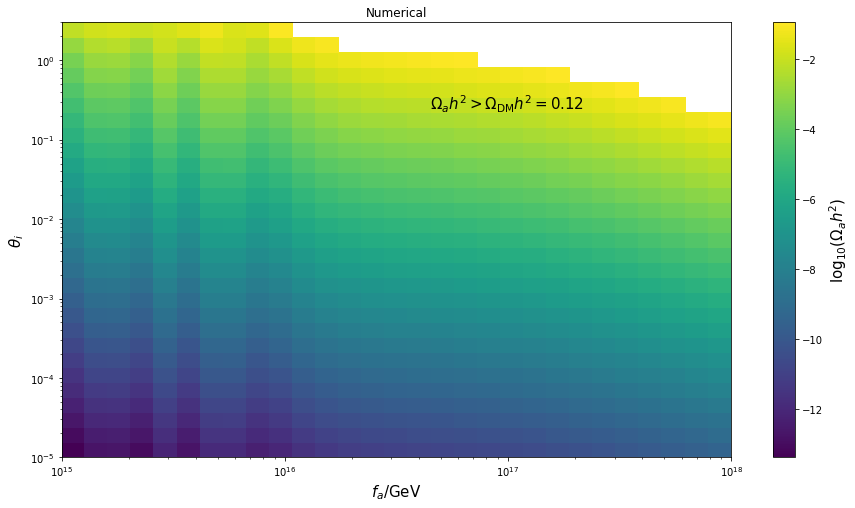

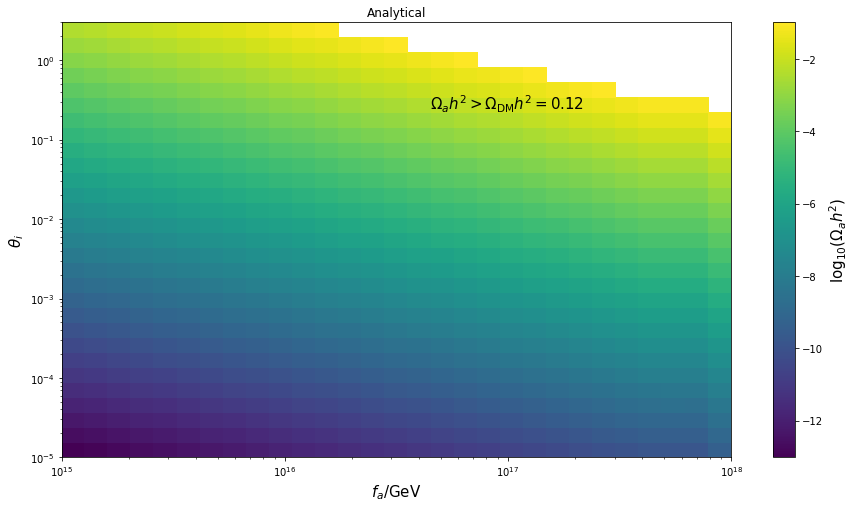

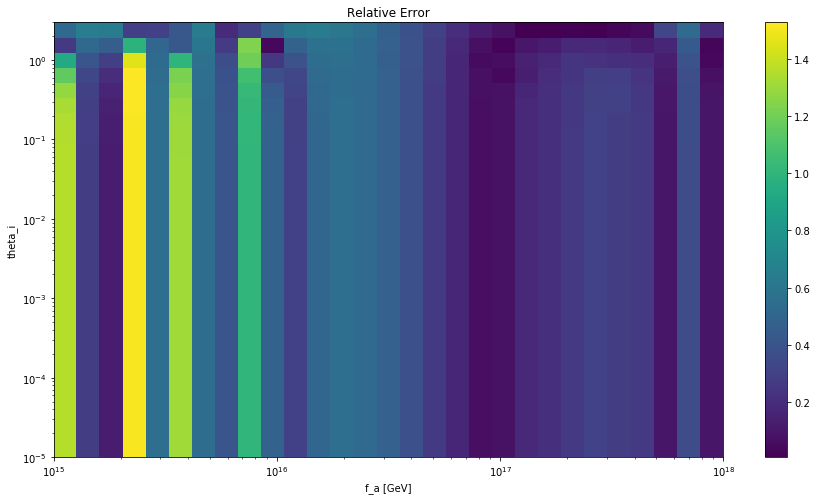

In [10]:
plt.figure(figsize=(15,8))
plt.title("Numerical")
density_plot.plot_density(theta_i, f_a, Omega_numerical)
plt.show()
plt.figure(figsize=(15,8))
plt.title("Analytical")
density_plot.plot_density(theta_i, f_a, Omega_analytic)
plt.show()
plt.figure(figsize=(15,8))
plt.title("Relative Error")
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.xlabel("f_a [GeV]")
plt.ylabel("theta_i")
plt.pcolormesh(f_a / 1e9, theta_i, np.abs(Omega_analytic - Omega_numerical) / Omega_numerical)
plt.colorbar()

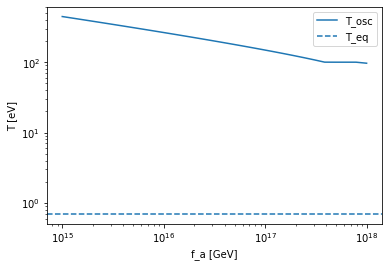

In [6]:
T_i_s = [time_temp.find_T_osc(f,                                        
                      lambda T, f: axion_mass.micro_m_a(T, f, 1e2, parameter_estimation_micro_qcd.zeta_mean),                                    
               g_star.make_micro(parameter_estimation_micro_qcd.Delta_N_eff_mean))   
     for f in f_a]                                                  
                                              
plt.loglog(f_a / 1e9, T_i_s, label="T_osc")                     
plt.axhline(config.parameter.T_eq, label="T_eq", linestyle="--")
plt.xlabel("f_a [GeV]")                             
plt.ylabel("T [eV]")                          
plt.legend() 

In [52]:
def T_neutrino(T):
    if(T < 1e-2 * 1e6):
        return pow(4.0 / 11, 1/3.) * T;
    else:
        f = pow(8*(g_star.shellard_fit.g_s(T) - 2) / (7.*6), 1./3);
        if(f < 1.0):
            return f * T;
        else:
            return T;

In [17]:
T = np.geomspace(1e-2, 10, 300) * 1e6

In [55]:
def Delta_N_eff(T):
    T_prime = T / 4
    N_prime = 31
    return 8 / 7 * (T_prime / T_neutrino(T))**3 * N_prime

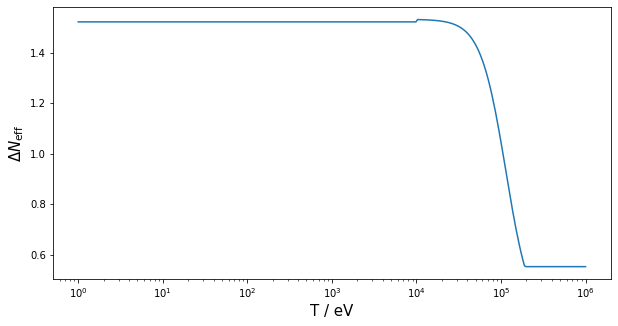

In [56]:
plt.figure(figsize=(10,5))
plt.xlabel("T / eV", fontsize=15)
plt.ylabel(r"$\Delta N _ \mathrm{eff}$", fontsize=15)
plt.semilogx(T, list(map(Delta_N_eff, T)))

In [4]:
import t_ratio_parameter_estimation
df = np.load(config.data_path + "/T_ratio_micro_qcd_parameter.npz")
samples = df["samples"]
single_chains = samples.reshape((-1, 5))
names = t_ratio_parameter_estimation.parameter_names

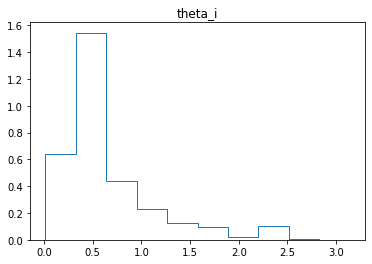

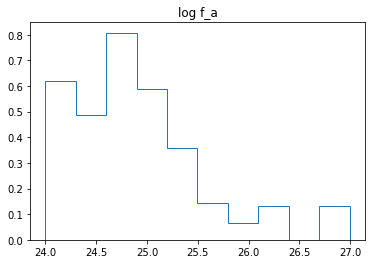

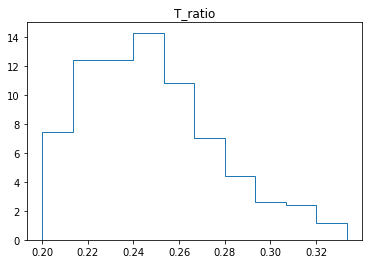

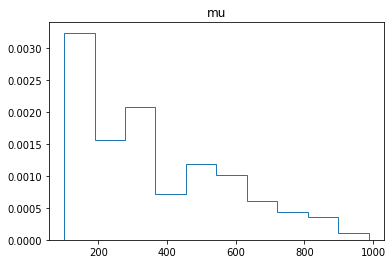

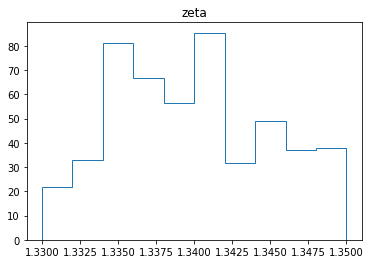

In [5]:
for i, name in enumerate(names):
    plt.title(name)
    plt.hist(single_chains[:, i], density=True, histtype="step", label="Posterior")
    if name == "Delta_N_eff":
        Delta_N_effs = single_chains[:, i]
        Delta_N_eff_expectation_value = np.mean(Delta_N_effs)
        plt.axvline(Delta_N_eff_expectation_value, label="Expectation Value %e" % Delta_N_eff_expectation_value, 
                    color="black", linestyle="--")
        Delta_N_effs = np.linspace(np.min(Delta_N_effs), np.max(Delta_N_effs), 300)
        plt.plot(Delta_N_effs, np.exp(parameter_estimation_micro_qcd.log_gaussian(Delta_N_effs,
            parameter_estimation_micro_qcd.Delta_N_eff_mean, parameter_estimation_micro_qcd.Delta_N_eff_err)),
                label="Prior Distribution")
        plt.legend()
    plt.show()

(-0.1, 10)

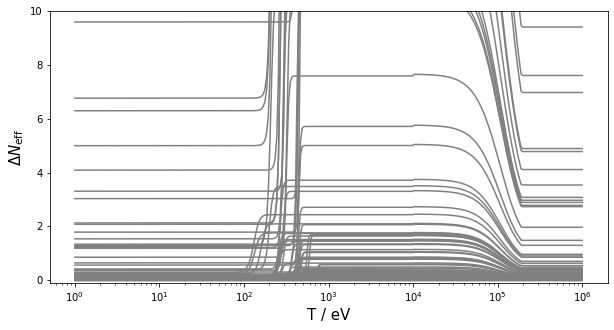

In [57]:
def Delta_N_eff(T, T_ratio, mu):
    T_prime = T_ratio * T
    a = 5e-2
    N_prime = (31 - 3.5) / 2 * np.tanh(a * T - a * mu) + (31 + 3.5) / 2
    return 8 / 7 * (T_prime / T_neutrino(T))**4 * N_prime

T = np.geomspace(1, 1e6, 300)

plt.figure(figsize=(10,5))
plt.xlabel("T / eV", fontsize=15)
plt.ylabel(r"$\Delta N _ \mathrm{eff}$", fontsize=15)

i = np.random.choice(single_chains.shape[0], 100, replace=False)
t_ratios = single_chains[i, 2]
mus = single_chains[i, -2]
for t_ratio, mu in zip(t_ratios, mus):
    plt.semilogx(T, list(map(lambda T: Delta_N_eff(T, t_ratio, mu), T)), color="grey")
plt.ylim((-0.1, 10))

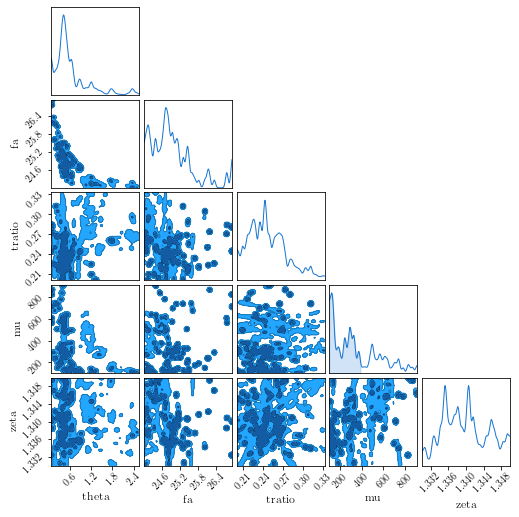

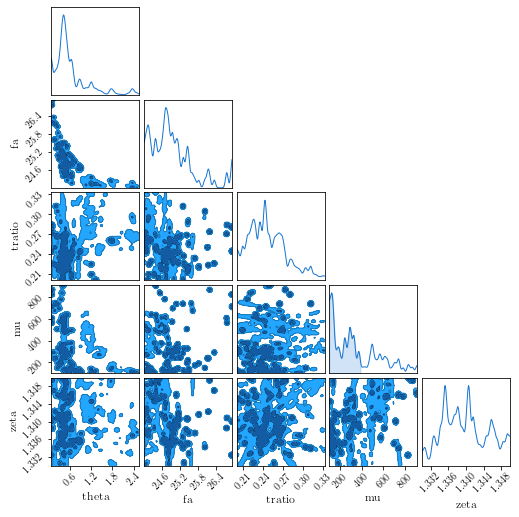

In [17]:
c = chainconsumer.ChainConsumer()
names = ["theta", "fa", "tratio", "mu", "zeta"]
c.add_chain(single_chains, parameters=names)
c.plotter.plot()